In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/Shareddrives/vae-asr/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/vae-asr


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
sys.path.append('/content/drive/Shareddrives/vae-asr/modules')
from model import VAE
# help(VAE)
from data import MSA_Dataset
# help(MSA_Dataset)

## Run script to pre-process the VAE

Query sequence for PF00565_full: SND1_HUMAN/552-660. Outgroup accession will be A0A060HE43, which is a sequence on an Archaea

Query sequence for PF00041_full: TENA_HUMAN/804-884 (this is the same choice as original paper: https://github.com/BrooksResearchGroup-UM/PEVAE_Paper/blob/master/pfam_msa/script/proc_msa.py). Outgroup accession will be A0A023BR93, which is a sequence on a *Aquimarina atlantica*, a type of bacteria.

Query sequence for PF00067_full: A0A8J5V3X2_ZIZPA/310-424 (chosen for its sparsity so that eliminating sequences that have too many gaps where the query sequence has a letter does not result in very few remaining sequences). Outgroup accession will be A0A010Z6J1, a type of bacteria



In [3]:
MSA_id = "PF00041_full"
query_seq_id = "TENA_HUMAN/804-884"
outgroup_acc = "A0A023BR93"

In [ ]:
# !grep {query_seq_id} data/pevae_real/{MSA_id}.txt

The script writes the processed MSA objects as `.pkl` files in the `output/` directory.

In [ ]:
#! python scripts/proc_msa.py data/pevae_real/{MSA_id}.txt {query_seq_id} {outgroup_acc}

Check resulting processed MSA

In [4]:
#Number of sequences
! wc -l ./output/{MSA_id}/seq_msa_char.txt

43699 ./output/PF00041_full/seq_msa_char.txt


In [5]:
#First few sequences
!head -n 25 ./output/PF00067_full/seq_msa_char.txt | awk '{print $2}'

RVHKEIDEVIGPDRPPMMEDRVKMPYTDAVVHEVQRSMDLAPAVPHKVMRDTEFHNYHIPEGTLVLPLISSVLADPQLWKNPNHFDPENFLDDAGHFQKNDAYECY
KILQEIKTNLPRTSDSMQYYLNKLVYLRGALYEAMRLYPPVPERMSPI.NPDKLPSHKVDASMKILIFIYALGRMEAVWEDALEFKPERWVSKTGIEEPSYKRMKH
KAQEEIRASLGTKGKVEEEDLHQLQYLKSVVKETWRLHSPAPLLPRESVRHSRIHGYDILPNTRVYVNAWGIAKDPKSWDDPEEFIPERFMDGPIDYGHNFELHLV
KVKKELTDVVGLDRTVEEFHLPNLRYLNAVIKETFRLHPALPLVPRCSGKSITVGGYTIPKGSRVFLNIWSIHRDPHIWDNPLQFQPDRFLNDPDDYGSDFRLLI.
KAVDELDMVVGKERLVEESDIHSLTYLKACIREAFRIHPYHPNPSHVAIADITIAGFMIPKGSHIILSRIGLGRNPRAWDNPLEFRPERHLKNTNLVEPELRLLMQ
RLASEIRSTFSSRCIRAGHELHNCKYLRAVIDETMRMSPSSLPAWRS.QDVFTVDGHVIPPGTQVGSSRYAVQHNEAFFPEPFKFQPERWLSSEDARAMRRAAGNL
RCREEVQMLLREREEIEWEDLSQLPFLTMCIKESLRLHPPVTVISRCTTQDVVLPDRVIPKGNICTISIFGIHHNPSVWPEPEVYNPFRFDPETPQKRSPLARAEE
KLSLELERAELSGAVVSSEQAQNLAYLRACIREALRFAPTVSQLPRLAPRDTELHGEHVPPGYSVSTSPWVLGRSERLYPDAHVYRPERWLEAAEEQYWDRNAEVR
RLAAEVDSARRQSTIIPADLCDRLPFLDAVVKETLRLYAPIPSQPRTSTRDMTVDGHLIPAGTVVSCQAYSLHRNPDVFRHPYKFNPDRWLAGDAEVEMRRWPTAT
KARSEINHNVQG.RLLDDSDLAKLPYLHCIINETLRM

## Load data and instantiate dataset

In [6]:
## read multiple sequence alignment in binary representation
with open(f"./output/{MSA_id}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([43699, 73, 21])

In [7]:
## each sequence has a label
with open(f"./output/{MSA_id}/keys_list.pkl", 'rb') as file_handle:
    msa_keys = pickle.load(file_handle)
msa_keys[:10]

['TENA_HUMAN/804-884',
 'A0A8I5N0T3_PAPAN/1664-1744',
 'A0A671K1Y1_9TELE/822-901',
 'A0A8C9XQA9_SANLU/809-899',
 'A0A672I963_SALFA/90-173',
 'A0A6P7I4P6_9TELE/710-790',
 'A0A6J1R157_9HYME/1216-1302',
 'A0A8C3Y235_CATUS/1543-1624',
 'A0A8I3S7D8_CANLF/650-736',
 'A0A674JR42_TERCA/750-831']

In [8]:
## sequences in msa are weighted
with open(f"./output/{MSA_id}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
seq_weight[:10]

array([1.8015216e-05, 1.4309448e-05, 2.2219396e-05, 3.9263919e-05,
       2.0673364e-05, 1.8960754e-05, 1.8530151e-05, 1.0886213e-05,
       1.8244087e-05, 1.7570952e-05], dtype=float32)

In [9]:
data = MSA_Dataset(msa_binary, seq_weight, msa_keys)
# Show a random sample
data[100]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]),
 3.280277e-05,
 'A0A6J3IQN5_SAPAP/884-968')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [11]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc, dim_latent_vars = 2)

Let's check that our model processes data the way we want it to

In [12]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[-0.0123,  0.0758]], grad_fn=<AddmmBackward0>), tensor([[1.0036, 0.9697]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 73, 21]) and is given by:
tensor([[[-3.1572, -2.8822, -3.2042,  ..., -3.0895, -3.1316, -2.8485],
         [-2.9933, -2.9393, -2.8995,  ..., -2.9125, -3.1160, -3.1370],
         [-3.1171, -3.1506, -3.0070,  ..., -2.9754, -2.9509, -3.1298],
         ...,
         [-3.1468, -3.0016, -3.0157,  ..., -2.9800, -3.1750, -3.0293],
         [-3.0649, -2.9840, -3.1618,  ..., -3.0080, -2.9909, -3.0510],
         [-2.9873, -3.0200, -2.9895,  ..., -3.0711, -3.0481, -2.9231]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0425, 0.0560, 0.0406,  ..., 0.0455, 0.0436, 0.0579],
        [0.0501, 0.0529, 0.0551,  ..., 0.0543, 0.0443, 0.0434],
        [0.0443, 0.0428, 0.0494,  ..., 0.0510, 0.0523, 0.0437],
        ...,
        [0.0430, 0.0497, 0.0490,  ..., 0.0508, 

## Train model

We'll use K-fold cross validation to evaluate the training of the VAE. What this means in practice is that we partition the data into K equal-sized folds. Then for each fold, we train the VAE (for 30 epochs) using all data outside that fold and evaluate the trained model with the data from the fold.

In [16]:
from sklearn.model_selection import KFold
K= 5
# Initialize the k-fold cross validation
kf = KFold(n_splits=K, shuffle=True)

In [17]:
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}")
    print("Indices of first 10 validation examples:")
    print(valid_idx[:10])
    print("-------")

Fold 1
Indices of first 10 validation examples:
[ 3  6 13 14 17 23 28 31 32 34]
-------
Fold 2
Indices of first 10 validation examples:
[ 9 10 11 18 21 36 41 50 63 65]
-------
Fold 3
Indices of first 10 validation examples:
[ 4  7 19 26 35 46 47 49 51 57]
-------
Fold 4
Indices of first 10 validation examples:
[ 0  2 12 22 24 25 27 29 33 43]
-------
Fold 5
Indices of first 10 validation examples:
[ 1  5  8 15 16 20 30 38 52 56]
-------


In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == "cuda":
  model.cuda()

# Training hyperparameters
num_epochs = 30
weight_decay = 0.01
dim_lat = 2
batch_size = 128
verbose = False

# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_loss = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    loss_scalar = loss.data.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, loss_scalar), \
            flush = True)
    running_loss.append(loss_scalar)

  return running_loss

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100)
      elbo_scalar = torch.sum(elbo).data.item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, sigma = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



cuda


In [18]:
train_loss = {}
valid_elbos = {}
valid_recon_accs = {}
for fold, (train_idx, valid_idx) in enumerate(kf.split(data)):

  print(f"Fold {fold + 1}")
  print("-------")

  # put the training and validation data into separate dataloaders
  train_loader = DataLoader(dataset = data,
                           batch_size = batch_size,
                           sampler = torch.utils.data.SubsetRandomSampler(train_idx))

  valid_loader = DataLoader(dataset = data,
                           batch_size = batch_size,
                           sampler = torch.utils.data.SubsetRandomSampler(valid_idx))

  # Instantiate a new model for this fold
  model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
  optimizer = optim.Adam(model.parameters(), weight_decay = weight_decay)

  # Define a key in the dictionaries for storing the losses and elbos for this fold
  train_loss[fold+1] = []
  valid_elbos[fold+1] = []
  valid_recon_accs[fold+1] = []
  for epoch in range(num_epochs):

    batch_elbos, batch_recon_accs = eval(model, device, valid_loader, recon = True)
    epoch_val_elbo = np.mean(batch_elbos)
    epoch_val_recon_acc = np.mean(batch_recon_accs)
    print(f"Validation elbo for fold {fold + 1}, epoch {epoch}: {epoch_val_elbo}")
    print(f"Reconstruction accuracy for fold {fold + 1}, epoch {epoch}: {epoch_val_recon_acc}")
    valid_elbos[fold+1].append(epoch_val_elbo)
    valid_recon_accs[fold+1].append(epoch_val_recon_acc)

    batch_losses = train(model, device, train_loader, optimizer, epoch, verbose)
    epoch_ave_train_loss = np.mean(batch_losses)
    print(f"Training loss for fold {fold + 1}, epoch {epoch}: {epoch_ave_train_loss}")
    train_loss[fold+1].append(epoch_ave_train_loss)



  model.cpu()
  torch.save(model.state_dict(), "./output/{}/vae_fold{}_dimlat{}_{}_{:.2f}.model".format(MSA_id, fold+1, dim_lat, num_epochs, weight_decay))


Fold 1
-------
Validation elbo for fold 1, epoch 0: -28204.33499799952
Reconstruction accuracy for fold 1, epoch 0: 0.0420006531952084
Training loss for fold 1, epoch 0: 162.9644620018284
Validation elbo for fold 1, epoch 1: -19367.10594189579
Reconstruction accuracy for fold 1, epoch 1: 0.359975243392198
Training loss for fold 1, epoch 1: 154.9159219560832
Validation elbo for fold 1, epoch 2: -18865.290079383205
Reconstruction accuracy for fold 1, epoch 2: 0.37393203118573065
Training loss for fold 1, epoch 2: 152.96828054163578
Validation elbo for fold 1, epoch 3: -18696.303066661327
Reconstruction accuracy for fold 1, epoch 3: 0.3752467813699142
Training loss for fold 1, epoch 3: 151.77446796946282
Validation elbo for fold 1, epoch 4: -18540.968336548744
Reconstruction accuracy for fold 1, epoch 4: 0.38063468967658887
Training loss for fold 1, epoch 4: 150.9257996273737
Validation elbo for fold 1, epoch 5: -18417.81119747867
Reconstruction accuracy for fold 1, epoch 5: 0.38481124717

KeyboardInterrupt: 

In [ ]:
MSA_id

'PF00067_full'

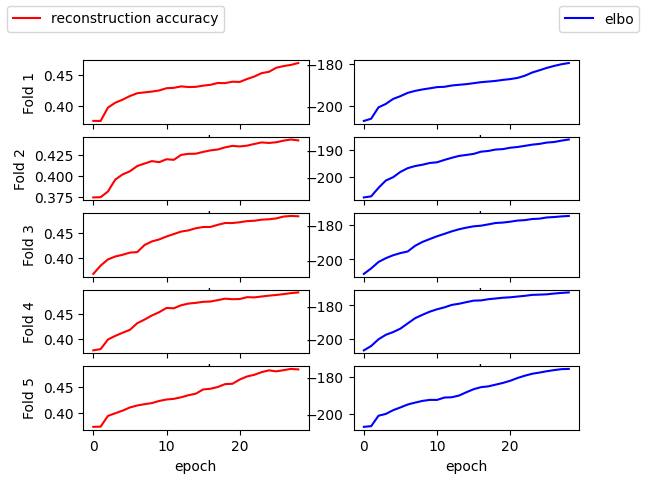

In [ ]:
fig, axs = plt.subplots(5, 2, sharex = "all")
for k in range(K):
  axs[k,0].plot(valid_recon_accs[k+1][1:], label = "reconstruction accuracy", color = 'r')
  #plt.plot(test_loss_epoch, label = "test", color = 'b')
  #plt.ylim((140, 180))
  axs[k,0].set_xlabel('epoch')
  axs[k,0].set_ylabel(f"Fold {k+1}")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels,loc = "upper left")

for k in range(K):
  axs[k,1].plot([x/batch_size for x in valid_elbos[k+1]][1:], label = "elbo", color = 'b')
  #plt.plot(test_loss_epoch, label = "test", color = 'b')
  #plt.ylim((140, 180))
  axs[k,1].set_xlabel('epoch')
handles, labels = axs[0,1].get_legend_handles_labels()
fig.legend(handles, labels,  loc = "upper right")
